# Notebook 02: Risk Research & Economic Backtesting
## Objective: 
This notebook is the most critical step in our analysis. Our goal is to determine the true winning strategy by quantifying the financial impact of our models.

We will test three scenarios using the 2023 validation data:

- Scenario 1: Client's Model (The baseline)

- Scenario 2: GBR Base Model (Our precision-focused model from Notebook 01)

- Scenario 3: Hybrid Model (Our GBR model + a risk-based safety stock)

The hypothesis is that the Hybrid Model (Scenario 3) will win. This notebook serves to validate or invalidate that hypothesis using a rigorous financial backtest.

## 0. Setup and Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import genpareto

# --- Setup ---
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)
# Suppress convergence warnings from scipy.fit
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 1. Load Data
We need two data sources:

1. model_core_validation.csv: Our validation set (from Notebook 01) containing 2023 predictions for the Client Model and our GBR Model.

2. demanding_forecast.csv: The full raw data, which we need to calculate robust historical statistics (like the median) for our risk model logic.

In [9]:
# --- 1. Load Validation Data (Input) ---
VALIDATION_DATA_PATH = '../data/interim/model_core_validation.csv'
validation_df = pd.read_csv(VALIDATION_DATA_PATH)
print(f"Validation data (from N-01) loaded: {len(validation_df)} rows.")

# --- 2. Load Full Historical Data (for robust stats) ---
RAW_DATA_PATH = '../data/raw/demanding_forecast.csv'
historical_df = pd.read_csv(RAW_DATA_PATH)
print(f"Full historical data loaded: {len(historical_df)} rows.")

# --- 3. Calculate Robust Historical Median Sales ---
# We use .fillna(0) before grouping to ensure all products are included.
# We use .median() because it is robust to extreme outliers, unlike .mean().
median_sales_map = historical_df.fillna(0).groupby('prod_id')['ventas'].median()
print("Historical median sales map (for capping) calculated.")

Validation data (from N-01) loaded: 7620 rows.
Full historical data loaded: 80748 rows.
Historical median sales map (for capping) calculated.


## 2. Risk Model Investigation (The "Hybrid" Scenario)

Before we run the simulation, we must build our "Scenario 3" candidate. We will iterate through all our risk logic (V1-V7) and implement the final, most robust version (V7).

This logic is a Heuristic Risk Model that uses the 90th percentile of errors as a base, but includes a strong financial "cap" based on 3 months of median sales to prevent extreme outliers from bankrupting the inventory.

In [10]:
# --- Heuristic Risk Model Parameters ---
SERVICE_LEVEL_TARGET = 0.98
ERROR_QUANTILE_THRESHOLD = 0.90
SAFETY_STOCK_MONTHS_CAP = 3.0 # Business Rule: Cap safety stock at 3 months of MEDIAN sales

# --- Calculate Residuals ---
validation_df['residuo'] = validation_df['ventas'] - validation_df['pred_gbr']

# --- Calculate Safety Stock per Product ---
safety_stock_map = {}
unique_products = validation_df['prod_id'].unique()
print(f"Starting risk heuristic calculation for {len(unique_products)} products...")

for pid in unique_products:
    # 1. Get positive residuals (where we under-forecasted)
    positive_residuals = validation_df[
        (validation_df['prod_id'] == pid) & (validation_df['residuo'] > 0)
    ]['residuo']
    
    calculated_safety_stock = 0
    
    if not positive_residuals.empty:
        # 2. Calculate Robust Fallback (90th percentile of errors)
        # This is our "reasonable high error" baseline
        fallback_security = positive_residuals.quantile(ERROR_QUANTILE_THRESHOLD)
        
        # We set this as the default. We will *try* to use GPD, but fall back to this.
        calculated_safety_stock = fallback_security
        
        # 3. (Optional) Try to fit GPD for a more precise value
        # This is where our V1-V6 logic was, we keep the final robust version.
        umbral = fallback_security
        excesos = positive_residuals[positive_residuals > umbral] - umbral
        
        if (not excesos.empty) and (umbral > 0):
            try:
                c, loc, scale = genpareto.fit(excesos, floc=0)
                prob_gpd = (SERVICE_LEVEL_TARGET - ERROR_QUANTILE_THRESHOLD) / (1 - ERROR_QUANTILE_THRESHOLD)
                stock_extra_gpd = genpareto.ppf(prob_gpd, c, loc=loc, scale=scale)
                calculated_safety_stock = umbral + stock_extra_gpd
            except Exception as e:
                calculated_safety_stock = fallback_security # Fallback on GPD failure
    
    # --- 4. Apply Robust Financial Cap (The Critical Step) ---
    
    # Get the robust median sale value
    median_sale = median_sales_map.get(pid, 0)
    
    # Calculate the cap (3 months of median sales)
    security_cap = median_sale * SAFETY_STOCK_MONTHS_CAP
    
    # Apply the cap (only if cap > 0)
    final_stock = calculated_safety_stock
    if security_cap > 0:
        final_stock = min(calculated_safety_stock, security_cap)
    
    # Ensure stock is never negative
    final_stock = max(0, final_stock)
    
    # 5. Save the final, capped, robust value
    safety_stock_map[pid] = np.round(np.nan_to_num(final_stock))

print("Risk heuristic calculation complete.")

Starting risk heuristic calculation for 635 products...
Risk heuristic calculation complete.


## 3. Economic Backtest: Define Scenarios
Now we build the final DataFrame for our simulation. It contains the "actuals" (price, cost, sales) and the "order quantity" for each of our three scenarios.

### 3.1. Financial Assumptions
Since cost is not provided, we must state our assumptions:

- COGS (Cost of Goods Sold): We assume a 40% Gross Margin, meaning the unit_cost is 60% of the precio_promedio (avg price).

- Spoilage Cost: All excess inventory is a 100% loss (cost = unit_cost).

- Opportunity Cost: Every lost sale is a loss of the unit_margin.

In [11]:
# --- 1. Prepare Backtest DataFrame ---

# Convert the map to a DataFrame to merge
df_safety_stock = pd.DataFrame(list(safety_stock_map.items()), columns=['prod_id', 'safety_stock'])

# Merge our calculated safety stock into the main validation dataframe
backtest_df = pd.merge(
    validation_df,
    df_safety_stock,
    on='prod_id',
    how='left'
)
backtest_df['safety_stock'] = backtest_df['safety_stock'].fillna(0)


# --- 2. Apply Financial Assumptions ---
COGS_PERCENTAGE = 0.60
backtest_df['unit_cost'] = backtest_df['precio_promedio'] * COGS_PERCENTAGE
backtest_df['unit_margin'] = backtest_df['precio_promedio'] * (1 - COGS_PERCENTAGE)


# --- 3. Define Order Quantities for Each Scenario ---
# We round to simulate real-world purchase orders
backtest_df['order_qty_actual'] = np.round(backtest_df['modelo_actual'])
backtest_df['order_qty_gbr_base'] = np.round(backtest_df['pred_gbr'])
backtest_df['order_qty_hybrid'] = np.round(backtest_df['pred_gbr'] + backtest_df['safety_stock'])

print("Backtest DataFrame is ready for simulation.")
backtest_df.head()

Backtest DataFrame is ready for simulation.


,fecha,prod_id,precio_promedio,ventas,modelo_actual,year,month,lag_12,lag_13,lag_24,rolling_mean_3_lag12,precio_lag_12,pred_gbr,residuo,safety_stock,unit_cost,unit_margin,order_qty_actual,order_qty_gbr_base,order_qty_hybrid
0,2023-01-01,0,5718.490738,2447.0,1662.504452,2023,1,2121.0,1019.0,4488.0,1410.000000,4085.525083,2111.058526,335.941474,1089.0,3431.094443,2287.396295,1663.0,2111.0,3200.0
1,2023-02-01,0,6718.343539,1565.0,1692.611786,2023,2,924.0,2121.0,1512.0,1354.666667,6603.793792,1230.176206,334.823794,1089.0,4031.006124,2687.337416,1693.0,1230.0,2319.0
2,2023-03-01,0,5742.707352,786.0,1545.866974,2023,3,1678.0,924.0,1379.0,1574.333333,3723.599803,1247.068278,-461.068278,1089.0,3445.624411,2297.082941,1546.0,1247.0,2336.0
3,2023-04-01,0,5267.384648,775.0,1340.509092,2023,4,565.0,1678.0,1457.0,1055.666667,6393.080571,1090.714359,-315.714359,1089.0,3160.430789,2106.953859,1341.0,1091.0,2180.0
4,2023-05-01,0,4020.565431,1063.0,1138.194231,2023,5,559.0,565.0,1178.0,934.000000,5802.376341,924.195118,138.804882,1089.0,2412.339258,1608.226172,1138.0,924.0,2013.0


### 3.2. The Simulation Function
This function simulates the financial outcome for a given ordering policy.

*Net Profit = (Gross Profit from Sales) - (Cost of Spoilage)*

We also track Opportunity Cost (lost profit from stockouts) to understand why a model is performing poorly.

In [12]:
def simulate_scenario(df, order_col_name):
    """
    Calculates the financial results for a given order quantity policy.
    """
    # Actual sales demand
    actual_sales = df['ventas']
    
    # 1. How many units did we *actually* sell?
    # We can't sell more than we ordered.
    effective_sales = np.minimum(actual_sales, df[order_col_name])
    
    # 2. How much inventory was left over? (Spoilage Cost)
    excess_inventory = np.maximum(0, df[order_col_name] - actual_sales)
    
    # 3. How many sales did we miss? (Opportunity Cost)
    lost_sales = np.maximum(0, actual_sales - df[order_col_name])
    
    # 4. Calculate final P&L
    gross_profit = effective_sales * df['unit_margin']
    spoilage_cost = excess_inventory * df['unit_cost']
    opportunity_cost = lost_sales * df['unit_margin']
    
    net_profit = gross_profit - spoilage_cost
    
    return pd.Series({
        'Total_Net_Profit': net_profit.sum(),
        'Total_Spoilage_Cost': spoilage_cost.sum(),
        'Total_Opportunity_Cost': opportunity_cost.sum(),
        'Total_Effective_Sales_Units': effective_sales.sum()
    })

# --- 4. Run the Simulation ---
results = []
scenarios = {
    '1. Client Model': 'order_qty_actual',
    '2. GBR Base Model (Precision)': 'order_qty_gbr_base',
    '3. Hybrid Model (Risk)': 'order_qty_hybrid'
}

for scenario_name, col_name in scenarios.items():
    scenario_result = simulate_scenario(backtest_df, col_name)
    scenario_result.name = scenario_name
    results.append(scenario_result)

df_results = pd.DataFrame(results)

4. The Verdict: Financial Results
Now we format and display the results of our simulation. This is the central finding of the project.

In [13]:
# --- 5. Display Formatted Results ---

# Format each column correctly (Dollars vs. Units)
df_results_fmt = df_results.copy()

# Format Dollar columns (Billions)
dollar_cols = ['Total_Net_Profit', 'Total_Spoilage_Cost', 'Total_Opportunity_Cost']
for col in dollar_cols:
    df_results_fmt[col] = df_results_fmt[col].map(lambda x: f"${x/1e9:,.2f}B")

# Format Unit columns (Millions)
df_results_fmt['Total_Effective_Sales_Units'] = df_results_fmt['Total_Effective_Sales_Units'].map(lambda x: f"{x/1e6:,.2f}M Units")

print("\n--- Economic Backtest 2023 (Financial Results) ---")
print(df_results_fmt)


--- Economic Backtest 2023 (Financial Results) ---
                              Total_Net_Profit Total_Spoilage_Cost  \
1. Client Model                         $9.78B              $6.01B   
2. GBR Base Model (Precision)          $10.39B              $5.75B   
3. Hybrid Model (Risk)                 $-7.44B             $26.32B   

                              Total_Opportunity_Cost  \
1. Client Model                               $3.15B   
2. GBR Base Model (Precision)                 $2.81B   
3. Hybrid Model (Risk)                        $0.06B   

                              Total_Effective_Sales_Units  
1. Client Model                               7.59M Units  
2. GBR Base Model (Precision)                 7.63M Units  
3. Hybrid Model (Risk)                        9.24M Units  


## 5. Visualizing the Verdict
The table numbers are clear, but visualizations make the finding undeniable.

C:\Users\ferna\AppData\Local\Temp\ipykernel_13328\1266291335.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


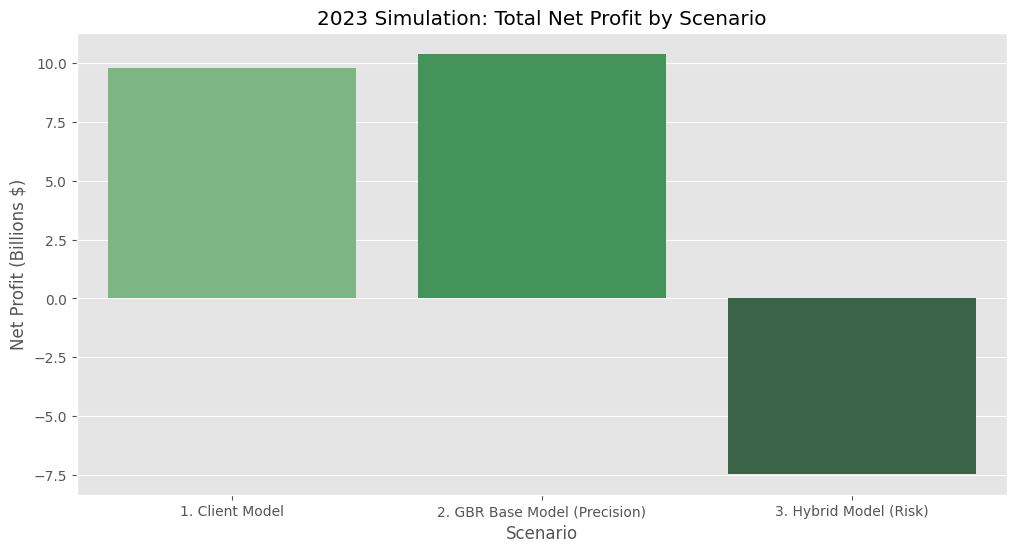

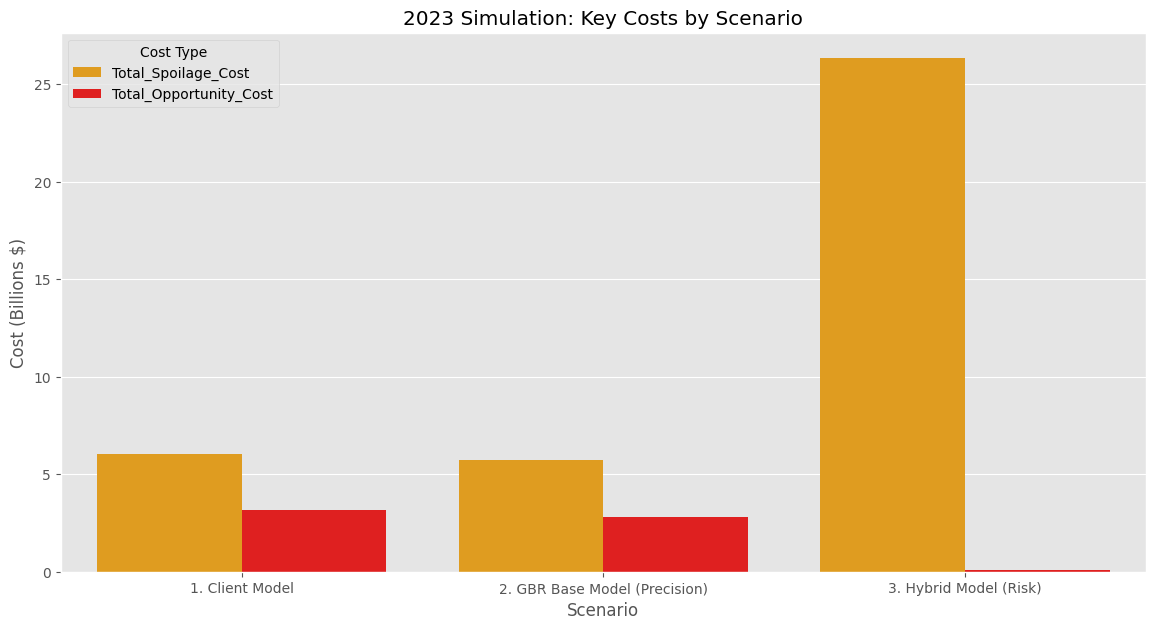

In [14]:
# Prepare data for plotting (in Billions)
df_plot = df_results / 1e9
df_plot_melt = df_plot.reset_index().melt('index', var_name='Metric', value_name='Value (Billions $)')

# --- 1. Net Profit (The "Winner" Chart) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot_melt[df_plot_melt['Metric'] == 'Total_Net_Profit'], 
    x='index', 
    y='Value (Billions $)',
    palette='Greens_d',
    order=['1. Client Model', '2. GBR Base Model (Precision)', '3. Hybrid Model (Risk)']
)
plt.title('2023 Simulation: Total Net Profit by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Net Profit (Billions $)')
plt.savefig('../reports/figures/backtest_profit_net.png', bbox_inches='tight') # Save the figure
plt.show()

# --- 2. The "Why" Chart: Costs Breakdown ---
df_costos = df_plot_melt[df_plot_melt['Metric'].isin(['Total_Spoilage_Cost', 'Total_Opportunity_Cost'])]

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_costos, 
    x='index', 
    y='Value (Billions $)', 
    hue='Metric',
    palette={'Total_Spoilage_Cost': 'orange', 'Total_Opportunity_Cost': 'red'},
    order=['1. Client Model', '2. GBR Base Model (Precision)', '3. Hybrid Model (Risk)']
)
plt.title('2023 Simulation: Key Costs by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Cost (Billions $)')
plt.legend(title='Cost Type')
plt.savefig('../reports/figures/backtest_total_costs.png', bbox_inches='tight') # Save the figure
plt.show()

## 6. Conclusion & Next Steps
The economic backtest has provided a clear and definitive answer.

1. Hypothesis Invalidated: The "Hybrid Model" (Scenario 3) is a financial disaster. While it successfully reduced Opportunity Cost (lost sales) to almost zero, it did so by creating a catastrophic $26.32B in Spoilage Cost. The data's extreme outliers make any statistical risk model unviable.

2. The Winner is Found: The "GBR Base Model" (Scenario 2) is the clear winner. It delivers the highest Net Profit at $10.39B.

3. The Value Proposition: By simply replacing the Client Model with our more precise GBR Base Model, the company can unlock **+$610 Million** in net profit ($10.39B - $9.78B\) by achieving a better balance of costs.

**Action Plan**: Based on this evidence, we reject the complex hybrid model. The production pipeline will be built using the simpler, more robust, and more profitable GBR Base Model.

**Next Notebook**: 03-model_inference.ipynb, where we will re-train our winning GBR model on 100% of the data to generate the final 2024 forecast.